<a href="https://colab.research.google.com/github/astroviki/TrafficAnalysis/blob/main/notebooks/NetworkAnomalyDetectionPandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import socket
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from google.colab import drive

## Běžne používané porty
Abychom mohli odfiltrovat běžný síťový provoz v případě, že takto budeme chtít učinit, definujeme slovník portů. Běžný síťový provoz je široký pojem, v tomto případě se nám jedná o identifikaci notoricky známých protokolů spjatých s definovanými porty. Pokud bychom zároveň získali hlavičky k protokolu bežícímu na daném portu a porovnali je s očekávanou hodnotou, budeme mít k dispozici silný nástroj pro detekci jedné z anomálií. Tento slovník zahrnuje běžné porty, včetně těch používaných pro vzdálenou správu, jako je TeamViewer (5938), VNC (5900 a 5800) a další. Porty jsou doplněny také o další informace.

In [ ]:
# Slovník s běžnými porty a jejich protokoly/aplikacemi
common_ports = {
    20: "FTP - File Transfer Protocol (Data Transfer)",
    21: "FTP - File Transfer Protocol (Control)",
    22: "SSH - Secure Shell",
    23: "Telnet - Unencrypted text communications",
    25: "SMTP - Simple Mail Transfer Protocol",
    53: "DNS - Domain Name System",
    80: "HTTP - Hypertext Transfer Protocol",
    110: "POP3 - Post Office Protocol v3",
    143: "IMAP - Internet Message Access Protocol",
    443: "HTTPS - Hypertext Transfer Protocol Secure",
    445: "SMB - Server Message Block",
    993: "IMAPS - IMAP over SSL",
    995: "POP3S - POP3 over SSL",
    1433: "MSSQL - Microsoft SQL Server",
    3306: "MySQL - MySQL Database Service",
    3389: "RDP - Remote Desktop Protocol",
    5060: "SIP - Session Initiation Protocol (non-encrypted)",
    5061: "SIP - Session Initiation Protocol (encrypted)",
    5900: "VNC - Virtual Network Computing",
    8080: "HTTP Proxy or Alternative HTTP Port",
    5938: "TeamViewer",
    5800: "VNC Web Interface",
    6530: "Remote Utilities",
    1701: "L2TP - Layer 2 Tunneling Protocol",
    1723: "PPTP - Point-to-Point Tunneling Protocol",
    1194: "OpenVPN",
    5000: "UPnP - Universal Plug and Play / Synology NAS",
    5357: "WSDAPI - Web Services on Devices",
    8443: "HTTPS Alternate / Apache Tomcat SSL",
    9100: "HP JetDirect Printing"
}


Připojíme se ke google disku, abychom načetli vzorek dodaných dat ze souboru *Doma-054000_2024_03_27.csv*. Data zpracujeme do výchozí tabulky Pandas DataFrame **df**. Tím si učiníme představu o struktuře dat, atributech spojených se sledováním síťového provozu a distribuci hodnot těchto atributů

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = '/content/drive/MyDrive/DataSource/NetworkTraffic/Doma-054000_2024-03-20.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path,delimiter=";")

# Funkce pro získání DNS záznamu
def get_dns_record(ip_address):
    try:
        return socket.gethostbyaddr(ip_address)[0]
    except socket.herror:
        return None
# Unix time format in second
df['TIME'] = df['TIME']/1.0e6

# Použití funkce apply pro přidání nového sloupce s DNS záznamy
df['DST DNS'] = df['DST IP'].apply(get_dns_record)

# Funkce pro mapování portů na typ
def map_port_type(port):
    return common_ports.get(port, 'undefined')

# Aplikace funkce na sloupec 'Src Port' a vytvoření nového sloupce 'Src Port Type'
df['DST Port Type'] = df['DST PORT'].apply(map_port_type)

# Vytvoření sloupce s četností IP adres
df['DST IP count'] = df['DST IP'].map(df['DST IP'].value_counts())

#Vytvoření sloupce s logaritmickou hodnotou velikosti ve sloupce 'DST BYTES'
df['DST LOG BYTES'] = np.log10(df['DST BYTES']+1e-10)
# Display the first few rows of the DataFrame

pd.options.display.float_format = '{:.5f}'.format
df.tail()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,TIME,DURATION,SRC IP,SRC PORT,DST IP,DST PORT,DUAL,PROTOCOL,APPLICATION,SRC PACKETS,DST PACKETS,SRC BYTES,DST BYTES,DST DNS,DST Port Type,DST IP count,DST LOG BYTES
2901,1710913512.16520,146500,192.168.5.131,54963,95.100.146.73,443,1,TCP,SSL,5,9,931,17553,a95-100-146-73.deploy.static.akamaitechnologie...,HTTPS - Hypertext Transfer Protocol Secure,1,4.24435
2902,1710913512.18635,153430,192.168.5.131,54962,2.19.11.155,443,1,TCP,SSL,5,9,957,19674,a2-19-11-155.deploy.static.akamaitechnologies.com,HTTPS - Hypertext Transfer Protocol Secure,1,4.29389
2903,1710913512.61222,11925,192.168.5.131,54735,192.168.5.1,53,1,UDP,DNS,1,1,45,45,None,DNS - Domain Name System,1461,1.65321
2904,1710913512.61224,10066,192.168.5.131,56152,192.168.5.1,53,1,UDP,DNS,1,1,45,77,None,DNS - Domain Name System,1461,1.88649
2905,1710913512.63957,102324,192.168.5.131,55556,216.239.32.36,443,1,UDP,UNKNOWN,19,13,6015,7414,None,HTTPS - Hypertext Transfer Protocol Secure,5,3.87005


### Frekvence četnosti opakování unikátních IP adres
Pro stanovení frekvence četnosti unikátních IP adres použijeme funkci *value_counts()* z knihovny *pandas*, která snadno určí četnost jednotlivých IP adres. Následně můžeš převést výsledek na nový DataFrame se dvěma sloupci: unikátní IP adresy a jejich četnost.

In [ ]:
def count_ip_frequencies(df, ip_column='DST IP'):
    """

    Args:
      df:
      ip_column:

    Returns:

    """
    # Použití value_counts pro zjištění četnosti IP adres
    ip_counts = df[ip_column].value_counts().reset_index()

    # Přejmenování sloupců
    ip_counts.columns = ['IP Address', 'Frequency']

    return ip_counts

# Filtrujeme IP adresy, které neodpovídají lokálnímu rozsahu 192.169.*
filtered_df = df[df['DST IP'].str.startswith('192.168.')]
# Odfiltrujeme data z nejčetnějšího zdroje 192.168.5.1, který nás nezajímá
filtered_df = filtered_df[filtered_df['DST IP'] != '192.168.5.1']

# Výpočet četnosti
result = count_ip_frequencies(filtered_df)

# Výsledná tabulka
result.columns = ['IP Address', 'Frequency']

# Filtr na IP adresy s četností větší než 1
filtered_ip_counts = result[result['Frequency'] > 1]


# Vytvoření interaktivního sloupcového grafu pomocí Plotly
fig = px.bar(filtered_ip_counts, x='IP Address', y='Frequency', title='Frequency of IP Addresses', labels={'Frequency': 'Count'},
             hover_name='IP Address')

# Zobrazení grafu
fig.show()

# Výpis výsledného DataFrame
filtered_ip_counts.head()


,IP Address,Frequency
0,192.168.89.70,11
1,192.168.5.131,10
2,192.168.100.100,2
3,192.168.210.100,2
4,192.168.0.120,2


In [ ]:
filtered_df = df[(df['SRC IP'] == '192.168.5.131') & (df['DST IP'] == '192.168.89.70')]

filtered_df

,TIME,DURATION,SRC IP,SRC PORT,DST IP,DST PORT,DUAL,PROTOCOL,APPLICATION,SRC PACKETS,DST PACKETS,SRC BYTES,DST BYTES,DST DNS,DST Port Type,DST IP count,DST LOG BYTES
1008,1710912056.47846,49291935,192.168.5.131,54315,192.168.89.70,80,1,TCP,HTTP,24,164,13702,207437,None,HTTP - Hypertext Transfer Protocol,11,5.31689
1013,1710912058.71199,6293072,192.168.5.131,54319,192.168.89.70,80,1,TCP,HTTP,22,182,14214,230848,None,HTTP - Hypertext Transfer Protocol,11,5.36333
1015,1710912059.02036,6527274,192.168.5.131,54321,192.168.89.70,80,1,TCP,HTTP,20,105,14069,124927,None,HTTP - Hypertext Transfer Protocol,11,5.09666
1016,1710912059.02076,5755445,192.168.5.131,54320,192.168.89.70,80,1,TCP,HTTP,16,115,11843,143139,None,HTTP - Hypertext Transfer Protocol,11,5.15576
1017,1710912059.02107,6209712,192.168.5.131,54322,192.168.89.70,80,1,TCP,HTTP,9,307,7196,414045,None,HTTP - Hypertext Transfer Protocol,11,5.61705
1406,1710912402.78177,3715211,192.168.5.131,54451,192.168.89.70,80,1,TCP,HTTP,16,75,12349,90280,None,HTTP - Hypertext Transfer Protocol,11,4.95559
1407,1710912402.78207,3792153,192.168.5.131,54450,192.168.89.70,80,1,TCP,HTTP,15,105,9989,134062,None,HTTP - Hypertext Transfer Protocol,11,5.12731
1408,1710912402.78791,4001652,192.168.5.131,54452,192.168.89.70,80,1,TCP,HTTP,13,172,9057,226760,None,HTTP - Hypertext Transfer Protocol,11,5.35557
1409,1710912402.78813,3953435,192.168.5.131,54453,192.168.89.70,80,1,TCP,HTTP,14,144,8922,188351,None,HTTP - Hypertext Transfer Protocol,11,5.27497
1410,1710912402.84475,3624920,192.168.5.131,54454,192.168.89.70,80,1,TCP,HTTP,7,254,5414,343415,None,HTTP - Hypertext Transfer Protocol,11,5.53582


### Distribuční funkce velikosti odeslaných packetů

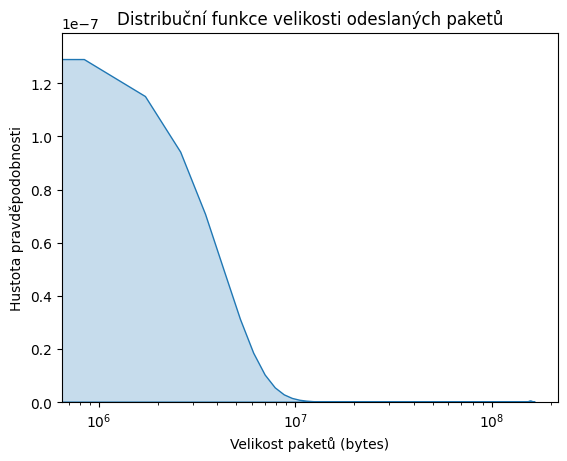

In [ ]:
filtered_df = df[df['DST BYTES'] > 10000]

# Vytvoření distribuce velikosti odeslaných paketů
sns.kdeplot(filtered_df['DST BYTES'], fill=True)

# Přidání názvu grafu a popisu os
plt.title('Distribuční funkce velikosti odeslaných paketů')
plt.xscale('log')
plt.xlabel('Velikost paketů (bytes)')
plt.ylabel('Hustota pravděpodobnosti')

# Zobrazení grafu
plt.show()


## Hledání časové korelace mezi zachycenými událostmi

Jednou z možných potencionálně zajímavých událostí může být časová korelace událostí v rámci síťového provozu mezi stejnými uzly. U síťové provozu nelze použít klasické metody pro hledání periodicity v časových řadách. Z logiky věci časová synchronizace je diskrétní jev, který se odehrává mezi jednotlivými událostmi (například se v rámci spojení opakuje některý typ spojení pravidelně v určitou dobu).

**Předpoklady**
- Hledáme korelace časových diferencí v rámci jedné dvojice DST IP a SRC IP
- Diference nejsou nutně po sobě jdoucí
- Diference nejsou v případě kladné časové korelace absolutně shodné, jde o statistickou shodu
- nezajímá nás spojení na cílovou adresu s prefixem 192.168.xxx. (neplatí v testovacích datech)

### **Verifikace metody na známé dvojici DST IP, SRC IP**

-  Vyfiltrujeme spojení mezi dvojicí adres SRC_IP=192.168.5.131 a DST_IP=192.168.5.70

- Přidan kod na konverzi unix time na čitelný formát, který je přidán jako sloupec do pandas DataFrame

``` # Funkce pro převod UNIX času na čitelný formát datumu a času

def unix_to_datetime(unix_timestamp):
    # Převede UNIX čas na objekt datetime
    dt = datetime.datetime.fromtimestamp(unix_timestamp)
    # Vrátí datum a čas ve formátu 'YYYY-MM-DD HH:MM:SS'
    return dt.strftime('%Y-%m-%d %H:%M:%S')

# Příklad UNIX času
unix_timestamp = 1711514407.403215

# Převeď UNIX čas na čitelný formát datumu a času
readable_date_time = unix_to_datetime(unix_timestamp)
```

In [ ]:
from scipy import stats


# Filtrujeme záznamy, pro dvojici DST IP = 192.168.5.70 a SRC IP = 192.168.5.131
filtered_df = df[(df['SRC IP'] == '192.168.5.131') & (df['DST IP'] == '192.168.89.70')]
filtered_df.loc[:, 'DATETIME'] = pd.to_datetime(filtered_df['TIME'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

filtered_df

<ipython-input-7-9be655f482b6>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,TIME,DURATION,SRC IP,SRC PORT,DST IP,DST PORT,DUAL,PROTOCOL,APPLICATION,SRC PACKETS,DST PACKETS,SRC BYTES,DST BYTES,DST DNS,DST Port Type,DST IP count,DST LOG BYTES,DATETIME
1008,1710912056.47846,49291935,192.168.5.131,54315,192.168.89.70,80,1,TCP,HTTP,24,164,13702,207437,None,HTTP - Hypertext Transfer Protocol,11,5.31689,2024-03-20 05:20:56
1013,1710912058.71199,6293072,192.168.5.131,54319,192.168.89.70,80,1,TCP,HTTP,22,182,14214,230848,None,HTTP - Hypertext Transfer Protocol,11,5.36333,2024-03-20 05:20:58
1015,1710912059.02036,6527274,192.168.5.131,54321,192.168.89.70,80,1,TCP,HTTP,20,105,14069,124927,None,HTTP - Hypertext Transfer Protocol,11,5.09666,2024-03-20 05:20:59
1016,1710912059.02076,5755445,192.168.5.131,54320,192.168.89.70,80,1,TCP,HTTP,16,115,11843,143139,None,HTTP - Hypertext Transfer Protocol,11,5.15576,2024-03-20 05:20:59
1017,1710912059.02107,6209712,192.168.5.131,54322,192.168.89.70,80,1,TCP,HTTP,9,307,7196,414045,None,HTTP - Hypertext Transfer Protocol,11,5.61705,2024-03-20 05:20:59
1406,1710912402.78177,3715211,192.168.5.131,54451,192.168.89.70,80,1,TCP,HTTP,16,75,12349,90280,None,HTTP - Hypertext Transfer Protocol,11,4.95559,2024-03-20 05:26:42
1407,1710912402.78207,3792153,192.168.5.131,54450,192.168.89.70,80,1,TCP,HTTP,15,105,9989,134062,None,HTTP - Hypertext Transfer Protocol,11,5.12731,2024-03-20 05:26:42
1408,1710912402.78791,4001652,192.168.5.131,54452,192.168.89.70,80,1,TCP,HTTP,13,172,9057,226760,None,HTTP - Hypertext Transfer Protocol,11,5.35557,2024-03-20 05:26:42
1409,1710912402.78813,3953435,192.168.5.131,54453,192.168.89.70,80,1,TCP,HTTP,14,144,8922,188351,None,HTTP - Hypertext Transfer Protocol,11,5.27497,2024-03-20 05:26:42
1410,1710912402.84475,3624920,192.168.5.131,54454,192.168.89.70,80,1,TCP,HTTP,7,254,5414,343415,None,HTTP - Hypertext Transfer Protocol,11,5.53582,2024-03-20 05:26:42


- Určení všech možných kombinací časových diferencí pro dvojici

In [ ]:
# Předpokládejme, že filtered_df je již definovaný DataFrame

# Krok 1: Seřaďte DataFrame podle sloupce 'TIME'
filtered_df_sorted = filtered_df.sort_values(by='TIME').reset_index(drop=True)

# Krok 2: Získejte počet řádků
N = len(filtered_df_sorted)

# Krok 3: Převod sloupců na NumPy pole pro efektivní zpracování
time = filtered_df_sorted['TIME'].values
src_ip = filtered_df_sorted['SRC IP'].values
dst_ip = filtered_df_sorted['DST IP'].values
ports = filtered_df_sorted['DST PORT'].values

# Krok 4: Získání všech indexů (i, j) kde j > i pomocí triu_indices
# Toto vytvoří dvojice indexů pro horní trojúhelník matice bez diagonály
i_indices, j_indices = np.triu_indices(N, k=1)

# Krok 5: Výpočet rozdílů v čase mezi těmito indexy
time_diffs = time[j_indices] - time[i_indices]

# Krok 6: Získání odpovídajících IP adres pro tyto indexy
src_ips = src_ip[i_indices]
dst_ips = dst_ip[j_indices]
ports = ports[i_indices]

# Krok 7: Sestavení výsledného DataFrame
results_df = pd.DataFrame({
    'TIMEDIFFS': time_diffs,
    'DST IP': dst_ips,
    'SRC IP': src_ips,
    'DST PORTS': ports
})



# Volitelně: Pokud chcete přidat výsledky do existujícího seznamu `results`, můžete to udělat následovně:
# results_list = results.to_dict('records')
print(results_df)



    TIMEDIFFS         DST IP         SRC IP  DST PORTS
0     2.23353  192.168.89.70  192.168.5.131         80
1     2.54190  192.168.89.70  192.168.5.131         80
2     2.54230  192.168.89.70  192.168.5.131         80
3     2.54261  192.168.89.70  192.168.5.131         80
4   346.30331  192.168.89.70  192.168.5.131         80
5   346.30361  192.168.89.70  192.168.5.131         80
6   346.30946  192.168.89.70  192.168.5.131         80
7   346.30968  192.168.89.70  192.168.5.131         80
8   346.36629  192.168.89.70  192.168.5.131         80
9   346.36648  192.168.89.70  192.168.5.131         80
10    0.30837  192.168.89.70  192.168.5.131         80
11    0.30877  192.168.89.70  192.168.5.131         80
12    0.30908  192.168.89.70  192.168.5.131         80
13  344.06978  192.168.89.70  192.168.5.131         80
14  344.07008  192.168.89.70  192.168.5.131         80
15  344.07592  192.168.89.70  192.168.5.131         80
16  344.07614  192.168.89.70  192.168.5.131         80
17  344.13

Celkový počet spojení je 9, přičemž pohledem na hodnoty je patrné, že se zde vyskytují dvě početnější skupiny: jedna skupina okolo hodnoty 855 a druhá okolo hodnoty 347

### Komplikace
 - Nutno optimalizovat, klasická iterace s pomocí cyklů je velmi pomalá.
 - Počet dat narůstá geometricky, za předpokladu že máme *m* různých cílových IP adres s četností větší než 4 a ke každé IP adrese máme $n_i$ záznamů, pak je celkový počet differencí $d$ dán vzorcem

 $$
d = \prod_{i=1}^{m}{n_i\choose 2}
 $$


Vzhledem k malému monožství dat reprezentujících podezřelé spojení ve zkoumaném vzorku použijeme pro další analýzu jinou dvojici IP adres, konkrétně zdrojová IP adresa 192.168.5.1 a cílová adresa 192.168.5.131

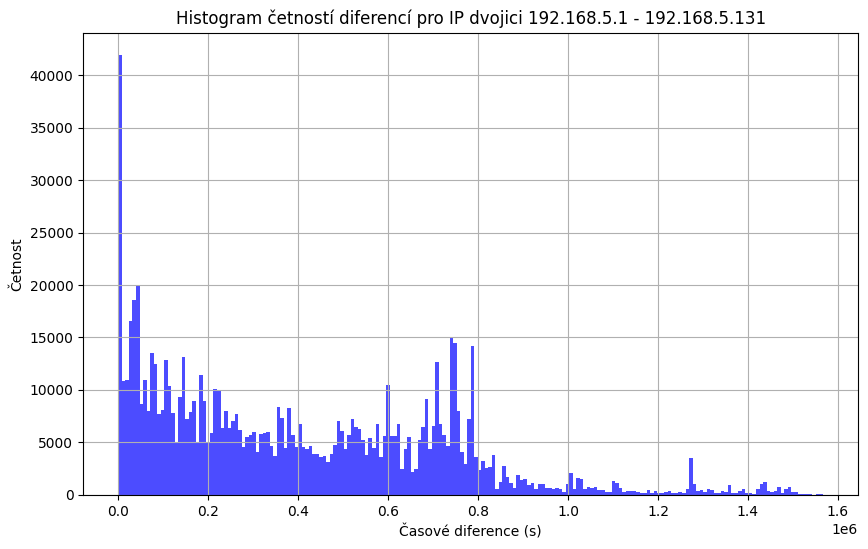

In [ ]:
# Vytváříme histogram četností časových diferencí pro dvojici
plt.figure(figsize=(10, 6))
plt.hist(results_df['TIMEDIFFS'], bins=200, color='blue', alpha=0.7)
plt.title(f'Histogram četností diferencí pro IP dvojici 192.168.5.1 - 192.168.5.131')
plt.xlabel('Časové diference (s)')
plt.ylabel('Četnost')
plt.grid(True)
plt.show()

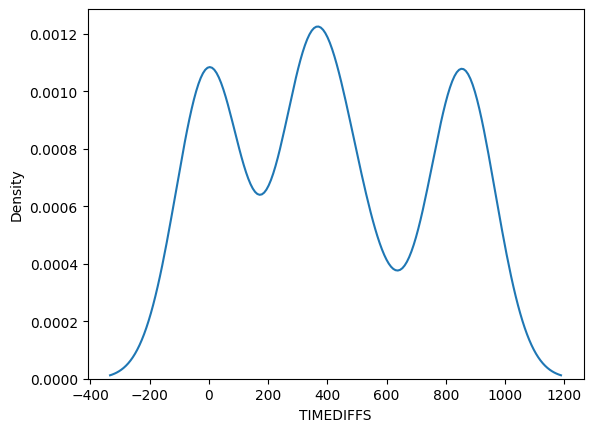

In [ ]:
sns.kdeplot(results_df['TIMEDIFFS'], bw_adjust=0.5)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_diff = scaler.fit_transform(results_df['TIMEDIFFS'].values.reshape(-1, 1))

print(scaled_diff)

[[ 0.28698335]
 [ 1.32541058]
 [ 1.32547533]
 [ 1.32557745]
 [-0.19145506]
 [-0.19139031]
 [-0.19128819]
 [-1.22981754]
 [-1.22971542]
 [-1.22978018]]


In [ ]:
from itertools import combinations
from sklearn.cluster import DBSCAN,OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Budeme ukládat výsledky pro každou skupinu
results = []

# Clusterová analýza pomocí HDBSCAN
scaler = StandardScaler()
scaled_diff = scaler.fit_transform(results_df['TIMEDIFFS'].values.reshape(-1, 1))

#dbscan = DBSCAN(eps=0.02, min_samples=2)  # Parametry je možné přizpůsobit
optics = OPTICS(eps=0.02, min_samples=2)  # Parametry je možné přizpůsobit
clusters = optics.fit_predict(scaled_diff)

# Přidání výsledků klastrování do DataFrame
results_df['Cluster'] = clusters
results_df

,TIMEDIFFS,DST IP,SRC IP,DST PORTS,Cluster
0,507.531111,192.168.89.70,192.168.5.131,80,0
1,854.980556,192.168.89.70,192.168.5.131,80,2
2,855.002222,192.168.89.70,192.168.5.131,80,2
3,855.036389,192.168.89.70,192.168.5.131,80,2
4,347.449444,192.168.89.70,192.168.5.131,80,0
5,347.471111,192.168.89.70,192.168.5.131,80,0
6,347.505278,192.168.89.70,192.168.5.131,80,0
7,0.021667,192.168.89.70,192.168.5.131,80,1
8,0.055833,192.168.89.70,192.168.5.131,80,1
9,0.034167,192.168.89.70,192.168.5.131,80,1


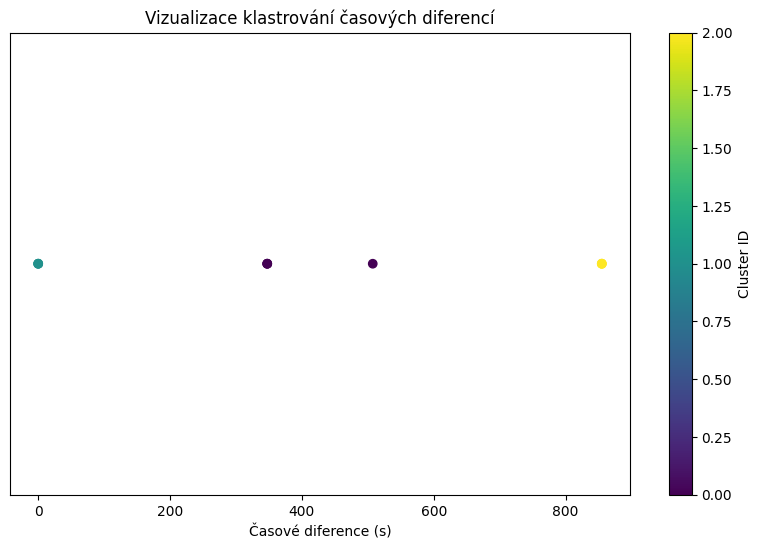

In [ ]:
# Vizualizace výsledků
plt.figure(figsize=(10, 6))
plt.scatter(results_df['TIMEDIFFS'], np.zeros_like(results_df['TIMEDIFFS']), c=results_df['Cluster'], cmap='viridis', marker='o')
plt.xlabel('Časové diference (s)')
plt.yticks([])
plt.title('Vizualizace klastrování časových diferencí')
plt.colorbar(label='Cluster ID')
plt.show()

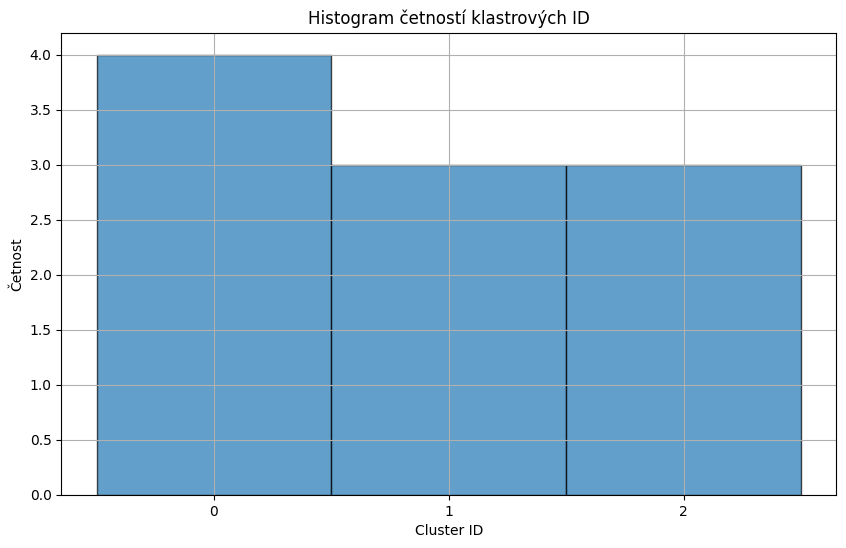

In [ ]:
# Histogram četnosti klastrů
plt.figure(figsize=(10, 6))
plt.hist(results_df['Cluster'], bins=np.arange(results_df['Cluster'].min(), results_df['Cluster'].max()+2) - 0.5, edgecolor='black', alpha=0.7)
plt.xticks(np.unique(results_df['Cluster']))
#plt.ylim(0,3000)
plt.xlabel('Cluster ID')
plt.ylabel('Četnost')
plt.title('Histogram četností klastrových ID')
plt.grid(True)
plt.show()


In [ ]:
from scipy import stats
# Filtrujeme IP adresy s četností větší než 4
filtered_df = df[df['DST IP count'] > 4]

# Funkce pro výpočet střední hodnoty a standardní chyby diferencí
def calculate_differences(ip_group):
    if len(ip_group) > 1:
        time_diffs = np.diff(np.sort(ip_group['TIME']))
        mean_diff = np.mean(time_diffs)/3600
        std_mean = stats.sem(time_diffs)/3600  # Statistická chyba průměru
        return pd.Series({'Mean difference': mean_diff, 'Std Mean': std_mean})
    else:
        return pd.Series({'Mean difference': 99999, 'Std Mean': 99999})

# Aplikujeme funkci na skupiny IP adres a přidáme výsledky do původního df
results = filtered_df.groupby('DST IP').apply(calculate_differences)

# Rozdělení výsledků do dvou nových sloupců
df['Mean difference'] = df['DST IP'].map(lambda x: results[x][0] if x in results else 99999)
df['Std Mean'] = df['DST IP'].map(lambda x: results[x][1] if x in results else 99999)


df.head()


<ipython-input-27-8cb8a24dce2a>:16: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



,TIME,DURATION,SRC IP,SRC PORT,DST IP,DST PORT,DUAL,PROTOCOL,APPLICATION,SRC PACKETS,DST PACKETS,SRC BYTES,DST BYTES,DST DNS,DST Port Type,DST IP count,DST LOG BYTES,Mean difference,Std Mean
0,1711514407403215,5690994615,192.168.5.131,5353,224.0.0.251,5353,0,UDP,UNKNOWN,799,0,286203,0,mdns.mcast.net,undefined,1,-inf,99999,99999
1,1711514452437446,1903054964,17.57.146.55,5223,192.168.5.131,52169,1,TCP,UNKNOWN,33,24,8040,842,None,undefined,12,2.925312,99999,99999
2,1711514453462529,9300,192.168.5.131,57830,192.168.5.1,53,1,UDP,DNS,1,1,43,43,None,DNS - Domain Name System,1290,1.633468,99999,99999
3,1711514453462547,917,192.168.5.131,61294,192.168.5.1,53,1,UDP,DNS,1,1,43,171,None,DNS - Domain Name System,1290,2.232996,99999,99999
4,1711514453574714,32094057,192.168.5.131,56294,17.248.213.64,443,1,TCP,SSL,16,9,49304,12445,None,HTTPS - Hypertext Transfer Protocol Secure,14,4.094995,99999,99999


##Isolation Forest
Isolation Forest je algoritmus pro detekci anomálií, který se zvláště hodí pro soubory dat s vysokou dimenzionalitou. Byl navržen jako efektivní způsob k nalezení anomálních datových bodů, které se odlišují od normálních pozorování.

###Jak funguje Isolation Forest:
Izolace: Algoritmus funguje na principu „izolace“ než na „shlukování“ nebo na vzdálenosti mezi body. Anomálie jsou izolovány rychleji než normální body – díky své vzácnosti a jedinečným vlastnostem. To znamená, že k izolaci anomálie je obvykle potřeba méně rozhodovacích kroků.

- Stromová struktura: Isolation Forest vytváří mnoho stromových struktur (nazývaných izolační stromy), kde každý strom je vytvořen náhodným vzorkováním dat a následným náhodným rozdělením bodů v datech na základě hodnoty atributů. Každý strom v lesní struktuře izoluje body dat tak, že výsledné sub-sady jsou rozděleny rekurzivním rozdělením.

- Hloubka stromu: Bod v datovém souboru se považuje za anomálii, pokud je izolován v nízké hloubce stromu. To znamená, že k dosažení izolace bylo potřeba méně rozdělujících kroků, což naznačuje jeho anomální povahu.

- Skóre anomálie: Výsledný model poskytuje skóre anomálie pro každý datový bod, kde vyšší skóre znamená vyšší pravděpodobnost být anomálií.

##Principal Component Analysis (PCA)
**PCA (Hlavní komponentová analýza)** je statistická metoda, která se používá k redukci dimenzí dat při zachování co největšího množství informací. PCA transformuje původní proměnné na nový soubor proměnných, které jsou lineárně nezávislé a jsou známé jako hlavní komponenty. Tyto hlavní komponenty jsou určeny tak, aby vysvětlily maximální možné množství variability v původních datech.

###Jak funguje PCA:
Standardizace: První krok v PCA je obvykle standardizace dat, kde každý atribut má průměr 0 a směrodatnou odchylku 1.

1. Kovarianční matice: PCA vypočítá kovarianční matici původních dat, která ukazuje, jak jsou proměnné mezi sebou korelovány.

2. Eigenvektory a eigenhodnoty: Z kovarianční matice jsou pak určeny eigenvektory a eigenhodnoty. Eigenvektory reprezentují směry (tj. hlavní komponenty) nového prostoru proměnných, zatímco eigenhodnoty udávají jejich relativní důležitost.

3. Transformace: Datové body jsou nakonec transformovány do tohoto nového prostoru. První hlavní komponenta má největší možnou varianci, a každá následující komponenta v řadě má nižší varianci.

###Výhody PCA pro vizualizaci:
Redukce dimenzí: PCA umožňuje zobrazit multidimenzionální data v nižších dimenzích (např. 2D nebo 3D), což usnadňuje vizuální inspekci a odhalení vzorů v datech.
Interpretace dat: Díky PCA je možné identifikovat a odstranit šum a zjistit strukturu v datech, která je užitečná pro další analýzu.

Kombinace Isolation Forest pro detekci anomálií a PCA pro vizualizaci výsledků poskytuje silný nástroj pro identifikaci a vizuální interpretaci anomálií v datech.

### Výchozí předpoklady pro analýzu outlierů v rámci běžného provozu
- Zvolená metoda *IsolationForest*

- Zajímají nás atributy ke spojení: Četnost, Log Bytes, Doba trvání, Port

- Všechny atributy jsou číselné

- Pro grafické znázornění bodů anomálií v případe 4 dimenzionálního prostoru atributů zvolíme znázornění v ve 2 osách určených metodou PCA.

- Filtrace vstupních dat: DST IP není z rozsahu 192.168.*.*, četnost IP > 4 a velikost $log$(bytes) je definována



In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Filtrace dat
#filtered_df = df[(df['DST IP count'] > 4) & (np.isfinite(df['DST LOG BYTES']))]
filtered_df = df[(df['DST IP count'] > 4) & (~df['DST LOG BYTES'].isin([np.inf, -np.inf])) & (~df['DST IP'].str.startswith('192.168.'))].copy()


# Výběr relevantních sloupců pro analýzu
features = filtered_df[['DST PORT', 'DURATION', 'DST LOG BYTES', 'DST IP count']]

# Normalizace dat
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Detekce anomálií pomocí Isolation Forest
iso_forest = IsolationForest(contamination=0.2)
predictions = iso_forest.fit_predict(features_scaled)

# PCA pro redukci dimenzí a vizualizaci
pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)

filtered_df['PCA1'] = components[:, 0]
filtered_df['PCA2'] = components[:, 1]
filtered_df['Anomaly'] = predictions

# Vizualizace pomocí Plotly
fig = px.scatter(filtered_df, x='PCA1', y='PCA2', color='Anomaly', labels={'Anomaly': 'Anomálie'},
                 hover_data=['DST IP', 'DST PORT'],
                 title='Vizualizace dat s Isolation Forest (Plotly)')
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()











# Clustering pomocí DBSCAN
#dbscan = DBSCAN(eps=0.5, min_samples=2)
#clusters = dbscan.fit_predict(scaled_features)

# Přidání sloupce s klustery
#filtered_df['Cluster'] = clusters

# Vizualizace výsledků
#plt.figure(figsize=(12, 6))

# Vizualizace anomálií
#plt.subplot(1, 2, 1)
#sns.scatterplot(data=filtered_df, x='DST IP count', y='DST LOG BYTES', hue='Anomaly', palette={1: 'blue', -1: 'red'})
#plt.title('Anomalie (červeně) vs. Normální data (modře)')
#plt.xlabel('DST PACKETS')
#plt.ylabel('DST LOG BYTES')

# Vizualizace clusterů
#plt.subplot(1, 2, 2)
#sns.scatterplot(data=filtered_df, x='DST IP count', y='DST LOG BYTES', hue='Cluster', palette='viridis')
#plt.title('Shluky (DBSCAN)')
#plt.xlabel('DST PACKETS')
#plt.ylabel('DST LOG BYTES')

#plt.tight_layout()
#plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` 

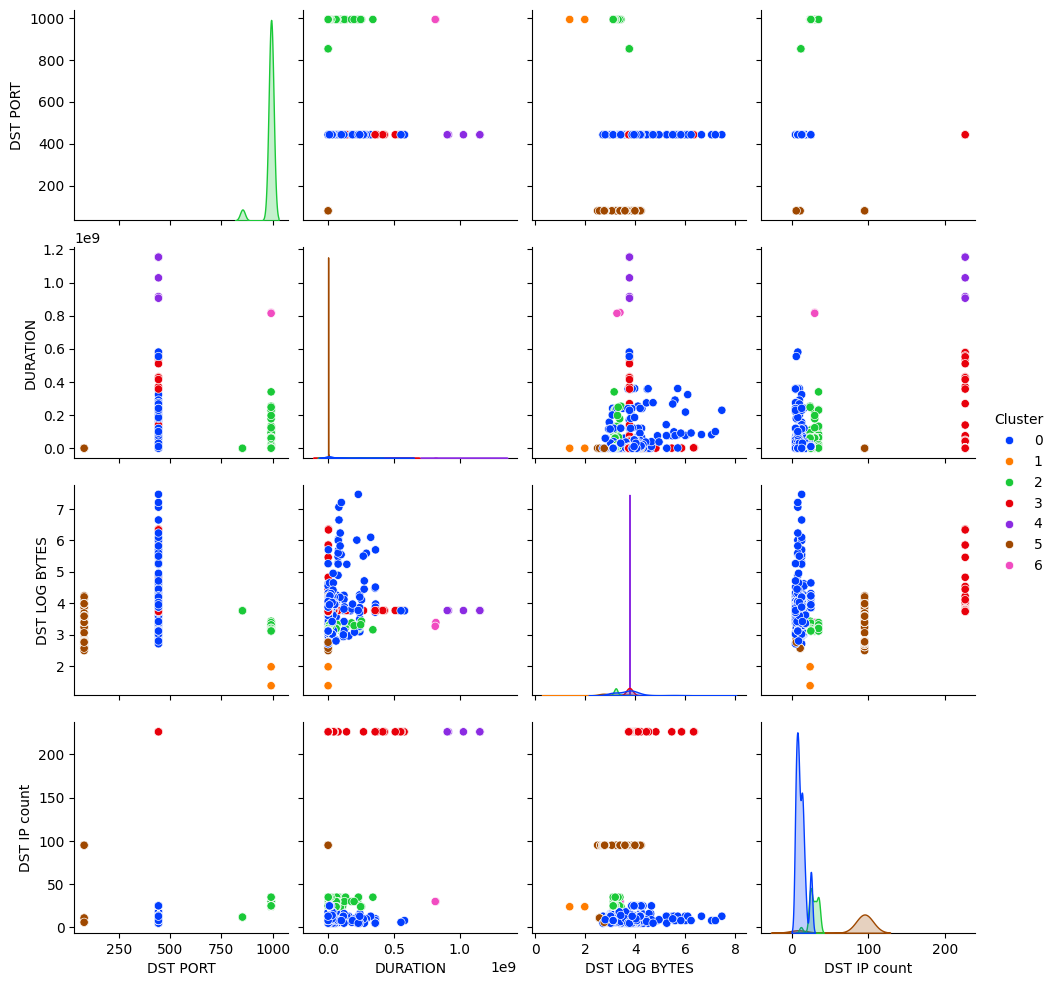

In [ ]:
# Vyber pouze relevantní sloupce
X = filtered_df[['DST PORT', 'DURATION', 'DST LOG BYTES', 'DST IP count']]

# Normalizace dat
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=2)
clusters = dbscan.fit_predict(X_scaled)

# Přidáme sloupec s cluster labels do DataFrame
filtered_df['Cluster'] = clusters

# Vizualizace pro každou dvojici atributů
sns.pairplot(filtered_df, vars=['DST PORT', 'DURATION', 'DST LOG BYTES', 'DST IP count'], hue='Cluster', palette='bright')
plt.show()

### Další věci nutné k vyjasnění

-  Nutné mít popsaná vstupní data, včetně identifikovaných zájmových událostí, incidentů
-  Kritické je především nastavení parametrů pro hledání časové korelovaných událostí
- Sumarizovat přesně podmínky, které nás zajímají:
- Snížit dimenzi analyzovaných dat s ohledem na známe cílové adresy (seznam českých a mezinárodních ardes)
- je nutné se zabývat spojením s malou četností a malým počtem přenesených dat ? Nastavit velikost ? **ANO, je nutné**.
- Přidat atribut související s hlavičkama paketů.
- Projekt 1.1. 2025: Výstup má být webová aplikace pro analýzu.
- Detekce stejné sekvence spojení v rácmi síťového provozu
- Detekce Časové korelace mezi nody
- Detekce anomálního přerušení spojení

In [ ]:
!pip install py2neo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
from py2neo import Graph

graph = Graph("bolt://95.111.247.47:7687", auth=("neo4j", "PcygHow2"))

In [ ]:
from py2neo import Node, Relationship

for index, row in df.iterrows():
    src_node = Node("IP", address=row['SRC IP'])
    dest_node = Node("IP", address=row['DST IP'])

    # Přidejte uzly do databáze (pokud ještě neexistují)
    graph.merge(src_node, "IP", "address")
    graph.merge(dest_node, "IP", "address")

    # Vytvořte relaci mezi zdrojovým a cílovým uzlem
    rel = Relationship(src_node, "CONNECTS_TO", dest_node, portdst=row['DST PORT'],
                       portsrc=row['SRC PORT'], protocol=row['PROTOCOL'])
    graph.merge(rel)


In [ ]:
# Najít všechny spojení z IP adresy '192.168.1.1'
query = """
MATCH (src:IP {address: '192.168.5.131'})-[r:CONNECTS_TO]->(dest:IP)
RETURN src, r, dest
"""
result = graph.run(query)

In [ ]:
from py2neo import Graph

# Připojení k databázi
graph = Graph("bolt://95.111.247.47:7687", auth=("neo4j", "PcygHow2"))

# Dotaz na počet uzlů
query_nodes = "MATCH (n) RETURN count(n) as count"
count_nodes = graph.run(query_nodes).data()
print("Počet uzlů v databázi:", count_nodes[0]['count'])

# Dotaz na počet vztahů
query_relationships = "MATCH ()-[r]->() RETURN count(r) as count"
count_relationships = graph.run(query_relationships).data()
print("Počet vztahů v databázi:", count_relationships[0]['count'])


Počet uzlů v databázi: 267
Počet vztahů v databázi: 269


In [ ]:
!pip install plotly networkx

In [ ]:
import plotly.graph_objects as go
import networkx as nx
from py2neo import Graph

# Připojení k Neo4j
graph_db = Graph("bolt://95.111.247.47:7687", auth=("neo4j", "PcygHow2"))

# Načtení dat z Neo4j
query = """
MATCH (src:IP)-[r:CONNECTS_TO]->(dest:IP)
RETURN src.address AS source, dest.address AS target, r.port AS port, r.protocol AS protocol
"""
data = graph_db.run(query)

# Vytvoření grafu NetworkX
G = nx.DiGraph()
for record in data:
    G.add_edge(record['source'], record['target'], port=record['port'], protocol=record['protocol'])

# Pozice pro uzly pomocí NetworkX
pos = nx.spring_layout(G)

# Pro extrakci dat do formátu Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])  # None způsobí přerušení linie mezi uzly
    edge_y.extend([y0, y1, None])

# Vytvoření stopy pro hrany
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

# Vytvoření stopy pro uzly
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        color=[],
        line_width=2))

# Přidání textu pro hover efekt u uzlů
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_info = f'{adjacencies[0]} (Connections: {len(adjacencies[1])})'
    node_text.append(node_info)

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Vytvoření figury a přidání stopy
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code powered by Plotly",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )

# Zobrazení grafu
fig.show()


In [ ]:
import plotly.graph_objects as go
import networkx as nx
from py2neo import Graph

# Připojení k Neo4j
graph_db = Graph("bolt://95.111.247.47:7687", auth=("neo4j", "PcygHow2"))

# Načtení dat z Neo4j
query = """
MATCH (src:IP)-[r:CONNECTS_TO]->(dest:IP)
RETURN src.address AS source, dest.address AS target, r.port AS port, r.protocol AS protocol
"""
data = graph_db.run(query)

# Vytvoření grafu NetworkX
G = nx.DiGraph()
for record in data:
    G.add_edge(record['source'], record['target'], port=record['port'], protocol=record['protocol'])

# Pozice pro uzly pomocí NetworkX ve 3D
pos = nx.spring_layout(G, dim=3)  # Parametr `dim=3` pro 3D pozice

# Příprava dat pro vizualizaci hran
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])  # None způsobí přerušení linie mezi uzly
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

# Vytvoření stopy pro hrany v Plotly 3D
edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    line=dict(width=2, color='#888'),
    hoverinfo='none',
    mode='lines')

# Příprava dat pro uzly
node_x = []
node_y = []
node_z = []
for node in G.nodes():
    x, y, z = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_z.append(z)

# Vytvoření stopy pro uzly v Plotly 3D
node_trace = go.Scatter3d(
    x=node_x, y=node_y, z=node_z,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        size=5,
        color=[],  # Barva bude nastavena podle počtu spojení
        colorscale='Viridis',
        line_width=2,
        opacity=0.8
    ))

# Přidání textu pro hover efekt u uzlů
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_info = f'{adjacencies[0]} (Connections: {len(adjacencies[1])})'
    node_text.append(node_info)

node_trace.marker.color = node_adjacencies  # Nastavení barev uzlů podle počtu spojení
node_trace.text = node_text  # Přiřazení textu pro hover efekt

# Vytvoření figury a přidání stopy
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>3D Network graph made with Python',
                    width=700,
                    height=700,
                    showlegend=False,
                    scene=dict(
                        xaxis=dict(showbackground=False, showticklabels=False, zeroline=False),
                        yaxis=dict(showbackground=False, showticklabels=False, zeroline=False),
                        zaxis=dict(showbackground=False, showticklabels=False, zeroline=False)),
                    margin=dict(b=0, l=0, r=0, t=0)))

# Zobrazení grafu
fig.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mode

def find_recurring_patterns(df, src_ip, dst_ip):
    """
    Identifikuje opakující se spojení mezi dvěma specifickými IP adresami na základě nejběžnějších intervalů.
    Parametry:
    df: pandas DataFrame obsahující logy síťového provozu
    src_ip: zdrojová IP adresa
    dst_ip: cílová IP adresa

    Vrátí: DataFrame s identifikovanými opakujícími se spojeními
    """
    # Filtruje události mezi specifickými IP adresami
    filtered_df = df[(df['Source IP'] == src_ip) & (df['Destination IP'] == dst_ip)]
    if filtered_df.empty:
        return pd.DataFrame()  # Vrátí prázdný df, pokud neexistují žádná spojení

    # Převod časových údajů na číselný formát pro analýzu
    filtered_df.sort_values('Time', inplace=True)

    # Výpočet rozdílů v časech mezi spojeními
    time_diffs = filtered_df['Time'].diff().dropna().values

    if time_diffs.size == 0:
        return pd.DataFrame()  # Vrátí prázdný df, pokud nejsou dostatečné data pro rozdíly

    # Identifikace nejběžnějšího intervalu
    result = mode(time_diffs)
    if result.count.size == 0:
        return pd.DataFrame()  # Vrátí prázdný df, pokud nebyl nalezen žádný modus

    common_interval = result.mode  # Správně načte modální hodnotu

    # Identifikace opakujících se spojení
    recurring_connections_list = [] # Use a list to store recurring connections
    for start_time in filtered_df['Time']:
        end_time = start_time + common_interval
        if end_time in filtered_df['Time'].values:
            recurring_connections_list.append(filtered_df[filtered_df['Time'] == start_time])
            recurring_connections_list.append(filtered_df[filtered_df['Time'] == end_time])

    # Concatenate the list of DataFrames into a single DataFrame
    recurring_connections = pd.concat(recurring_connections_list)
    return recurring_connections.drop_duplicates()

# Příklad použití
data = {
    'Source IP': ['192.168.1.1'] * 11,
    'Destination IP': ['10.10.10.10'] * 11,
    'Time': [0, 1.1, 1.4, 1.8, 2.6, 3.4, 4, 4.8, 5.6, 7.5, 8]  # Ukázka dat
}
df = pd.DataFrame(data)

# Zavolání funkce
recurring_connections = find_recurring_patterns(df, '192.168.1.1', '10.10.10.10')
print(recurring_connections)


     Source IP Destination IP  Time
4  192.168.1.1    10.10.10.10   2.6
5  192.168.1.1    10.10.10.10   3.4
6  192.168.1.1    10.10.10.10   4.0
7  192.168.1.1    10.10.10.10   4.8
8  192.168.1.1    10.10.10.10   5.6


In [ ]:
result

,IP Address,Frequency
0,85.207.218.179,226
1,77.75.76.99,95
2,142.250.102.109,35
3,142.250.27.109,30
4,31.170.176.244,25
...,...,...
256,77.75.79.63,1
257,99.80.254.97,1
258,2.16.238.21,1
259,142.251.36.150,1


In [ ]:
import pandas as pd
import numpy as np

# Ukázková data
data = {
    'TIME': [1609459200, 1609462800, 1609466400, 1609470000],  # Příklad Unix Timestamps
    'PORT': [80, 443, 80, 443],
    'PROTOKOL': ['HTTP', 'HTTPS', 'HTTP', 'HTTPS']
}
df = pd.DataFrame(data)

# Seřazení dat podle času
df.sort_values('TIME', inplace=True)

# Výpočet všech možných diferencí časů mezi událostmi
time_diffs = pd.Series([j - i for i in df['TIME'] for j in df['TIME'] if j > i])

# Odstranění duplicit a seřazení
unique_time_diffs = np.sort(time_diffs.unique())

print("Všechny možné časové diference mezi událostmi:", unique_time_diffs)


Všechny možné časové diference mezi událostmi: [ 3600  7200 10800]


In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Předpokládejme, že DataFrame se nazývá df a sloupec s časem je 'TIME'
# df = pd.read_csv('data.csv') # pokud je potřeba načíst data

# Ukázková data
data = {
    'TIME': [1609459200, 1609462800, 1609466400, 1609470000],  # Příklad Unix Timestamps
    'PORT': [80, 443, 80, 443],
    'PROTOKOL': ['HTTP', 'HTTPS', 'HTTP', 'HTTPS']
}
df = pd.DataFrame(data)


# Ujistíme se, že sloupec TIME je ve formátu datetime
df['TIME'] = pd.to_datetime(df['TIME'])

# Vytvoříme všechny možné dvojice indexů událostí
index_combinations = list(combinations(df.index, 2))

# Vypočítáme časové rozdíly mezi všemi dvojicemi událostí
time_diffs = []
for (i, j) in index_combinations:
    time_diff = (df.loc[j, 'TIME'] - df.loc[i, 'TIME']).total_seconds()
    time_diffs.append((i, j, time_diff))

# Vytvoříme nový DataFrame obsahující všechny časové rozdíly
diff_df = pd.DataFrame(time_diffs, columns=['Index1', 'Index2', 'TIME_DIFF'])

# Provedeme standardizaci časových rozdílů
scaler = StandardScaler()
diff_df['SCALED_DIFF'] = scaler.fit_transform(diff_df[['TIME_DIFF']])

# Provedeme clusterovou analýzu pomocí DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)  # Parametry je možné přizpůsobit
diff_df['CLUSTER'] = dbscan.fit_predict(diff_df[['SCALED_DIFF']])

# Identifikujeme opakující se vzory
repeating_patterns = diff_df[diff_df['CLUSTER'] != -1]  # -1 označuje šum

# Výpis výsledků
print(repeating_patterns)

# Pokud chceme zjistit, které cluster ID jsou nejvíce reprezentovány:
cluster_counts = repeating_patterns['CLUSTER'].value_counts()
print(cluster_counts)


   Index1  Index2  TIME_DIFF  SCALED_DIFF  CLUSTER
0       0       1   0.000003    -0.928477        0
1       0       2   0.000007     0.557086        1
3       1       2   0.000003    -0.928477        0
4       1       3   0.000007     0.557086        1
5       2       3   0.000003    -0.928477        0
CLUSTER
0    3
1    2
Name: count, dtype: int64
